In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn import tree
import math
import random
import cplex
df = pd.read_csv('HR_cat.csv')

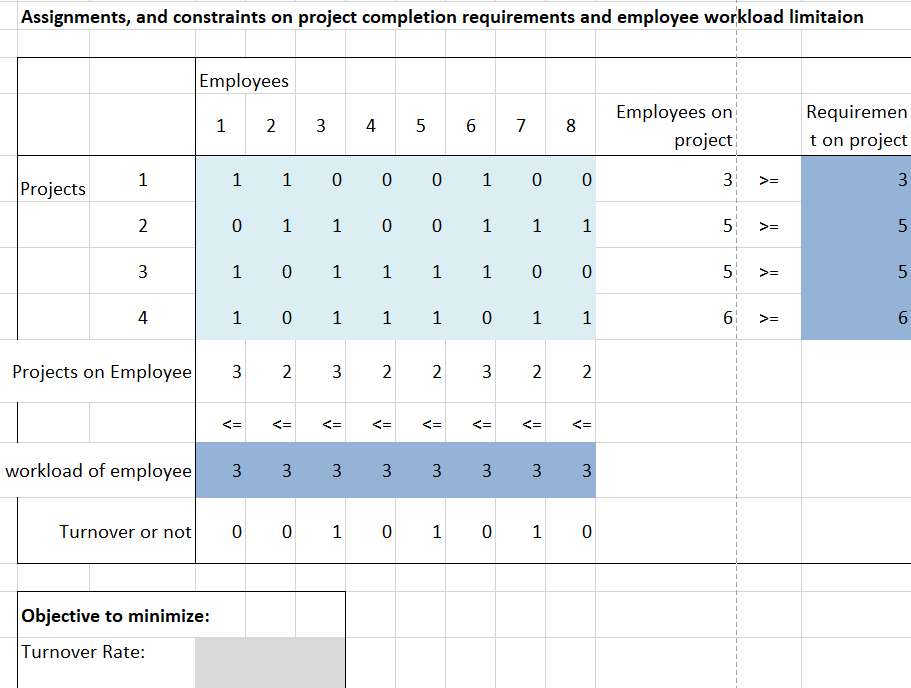

In [2]:
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y=df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)
print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))



 ---Decision Tree Model---
Decision Tree AUC = 0.94
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1715
          1       0.91      0.90      0.91       535

avg / total       0.96      0.96      0.96      2250



In [3]:
#######################################################################################
##################             Input Cells          ###################################
#######################################################################################
Num_Emp = 15
Num_Pro = 5
Require_on_Pro = [random.randint(4,7) for i in range(Num_Pro)]
Workload_of_Emp = 3
# we transform the assignment matrix to one-dimension vector
vec_domain = [(0,1) for i in range(Num_Emp*Num_Pro)]
#vec_domain is a list of 2-tuples that specify the minimum and maximum values for each variable

In [4]:
def s_point(E=Num_Emp,P=Num_Pro):
    #E= Amount of employees P= Amount of projects rhs the value of every constrains
    rhs = Require_on_Pro + [Workload_of_Emp]*Num_Emp
    #obj equals to factor
    obj=[1]*E*P
    #clonames is the name of all the variables
    colnames = [] 
    for j in range(P):
        a = ["x"+ str(j+1) + str(i+1) for i in range(E)]   
        colnames=colnames + a
    lower_bounds = [0]*E*P 
    upper_bounds = [1]*E*P 
    ctype = 'B'*E*P #type of variables ，"B" equals to binary
    sense = ["L"]*(E+P) #the relationshop between constrain and rows,“L” equals to less—than，“G”equals to bigger than，“E”equals to equals to
    rownames = ['r'+ str(i+1) for i in range(P)]+['c' + str(i+1) for i in range(E)]# the name of rows and columns, cplex use this names to locate the cosntrains
    p = cplex.Cplex()
    p.objective.set_sense(p.objective.sense.maximize)#because our final goal is to improve company's revenue, so I choose maximize
    p.variables.add(obj = obj, lb = lower_bounds, ub = upper_bounds, types = ctype, names = colnames)#add variables
    #the first loop is constrain of every row,the second loop is the constrain of every columns, every factor is 1 
    rows = []
    for j in range(P):
        a = [["x"+str(j+1) + str(i+1) for i in range(E)],[1]*E]
        rows.append(a)
    for j in range(E):
        b=[["x"+ str(i+1)+str(j+1) for i in range(P)],[1]*P]
        rows.append(b)
    p.linear_constraints.add(lin_expr = rows, senses = sense, rhs = rhs, names = rownames)
    #below is cplex doing solution
    p.solve()
    total = p.solution.get_objective_value()
    emp = p.solution.get_values()
    emp_in_matrix = []
    for i in range(P):
        a = emp[i*E:(i+1)*E]
        emp_in_matrix.append(a)
    emp_in_matrix = np.transpose(emp_in_matrix)
    result = []
    for i in emp_in_matrix:
        for p in i:
            result.append(p)
    return(result)
start_point = s_point()

Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 20 rows, 75 columns, and 150 nonzeros.
Reduced MIP has 75 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 20 rows, 75 columns, and 150 nonzeros.
Reduced MIP has 75 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.06 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       75.0000              --- 
*     0+    0                           33.0000       75.0000           127

In [5]:
def pro_on_Emp(vec1):
    #takes solution vector output the list of the project number every employee takes 
    pro_lst = []
    for i in range(Num_Emp):
        pro_lst.append(sum(vec1[Num_Pro*i:Num_Pro*(i+1)]))
    return pro_lst    

def peo_on_project(vec2):
    #takes solution vector output the list of the number of employees on every project
    peo_lst = []
    for i in range(Num_Pro):
        peo_lst.append(sum(vec2[i::Num_Pro]))
    return peo_lst

def assignment_matrix(vec):
    #takes solution vector output the matrix
    result = []
    for i in range(Num_Emp):
        result.append(vec[Num_Pro*i:Num_Pro*(i+1)])
    return pd.DataFrame(np.transpose(result))

def meet_const(vec):
    #test if the solution meet the contrasint
    peo_every_pros = peo_on_project(vec2 = vec)
    pro_every_emps = pro_on_Emp(vec1 = vec)
    for i in pro_every_emps:
        if i > Workload_of_Emp:
            return True
    for i in range(len(peo_every_pros)):
        if peo_every_pros[i] < Require_on_Pro[i]:
            return True
    return False




def randomoptimize(domain,costf):
    best=999999999
    bestr=None
    for i in range(0,1000000):
        # Create a random solution
        r=[float(random.randint(domain[i][0],domain[i][1])) 
            for i in range(len(domain))]
        if meet_const(r):
            # Get the cost
            cost=costf(r)

            # Compare it to the best one so fa  r
            if cost<best:
                best=cost  
                bestr=r 
    return r

def hillclimb(domain,costf):
    # Create a random solution
    sol=start_point
    # Main loop
    while 1:
        # Create list of neighboring solutions
        neighbors=[]
    
        for j in range(len(domain)):
            # One away in each direction
            if sol[j]>domain[j][0]:
                neighbors.append(sol[0:j]+[sol[j]+1]+sol[j+1:])
            if sol[j]<domain[j][1]:
                neighbors.append(sol[0:j]+[sol[j]-1]+sol[j+1:])

        # See what the best solution amongst the neighbors is
        current=costf(sol)
        best=current
        for j in range(len(neighbors)):
            cost=costf(neighbors[j])
            if cost<best:
                best=cost
                sol=neighbors[j]

        # If there's no improvement, then we've reached the top
        if best==current:
            break
    return sol

def annealingoptimize(domain,costf,T=10000.0,cool=0.95,step=1):
    # Initialize the values randomly
    vec=start_point
  
    while T>0.1:
        # Choose one of the indices
        i=random.randint(0,len(domain)-1)

        # Choose a direction to change it
        dir=random.randint(-step,step)

        # Create a new list with one of the values changed
        vecb=vec[:]
        vecb[i]+=dir
        if vecb[i]<domain[i][0]: vecb[i]=domain[i][0]
        elif vecb[i]>domain[i][1]: vecb[i]=domain[i][1]

        # Calculate the current cost and the new cost
        ea=costf(vec)
        eb=costf(vecb)
        p=pow(math.e,(-eb-ea)/T)

        # Is it better, or does it make the probability
        # cutoff?
        if (eb<ea or random.random()<p):
            vec=vecb      

        # Decrease the temperature
        T=T*cool
    return vec

def geneticoptimize(domain,costf,popsize=50,step=1,
                      mutprob=0.2,elite=0.2,maxiter=100):
    # Mutation Operation
    def mutate(vec):
        i=random.randint(0,len(domain)-1)
        if random.random()<0.5 and vec[i]>domain[i][0]:
            return vec[0:i]+[vec[i]-step]+vec[i+1:] 
        elif vec[i]<domain[i][1]:
            return vec[0:i]+[vec[i]+step]+vec[i+1:]
  
    # Crossover Operation
    def crossover(r1,r2):
        i=random.randint(1,len(domain)-2)
        return r1[0:i]+r2[i:]

    # Build the initial population
    pop=[]
    for i in range(popsize):
        vec=[random.randint(domain[i][0],domain[i][1]) 
            for i in range(len(domain))]
        pop.append(vec)
  
    # How many winners from each generation?
    topelite=int(elite*popsize)
  
    # Main loop 
    for i in range(maxiter):
        scores=[(costf(v),v) for v in pop if v != None]
        scores.sort()
        ranked=[v for (s,v) in scores]
    
        # Start with the pure winners
        pop=ranked[0:topelite]
    
        # Add mutated and bred forms of the winners
        while len(pop)<popsize:
            if random.random()<mutprob:

                # Mutation
                c=random.randint(0,topelite)
                pop.append(mutate(ranked[c]))
            else:
      
                # Crossover
                c1=random.randint(0,topelite)
                c2=random.randint(0,topelite)
                pop.append(crossover(ranked[c1],ranked[c2]))
    
        # Print current best score
        print (scores[0][0])
    
    return scores[0][1]


    

    

def get_turnover(vec,Num_E=Num_Emp,Num_P=Num_Pro):
    if vec != None:
        #this function takes the solution vector and assign projects to different employee and use machine learning to predict
        #total turnover numbers 
        peo_every_pros = peo_on_project(vec2 = vec)
        pro_every_emps = pro_on_Emp(vec1 = vec)
        if meet_const(vec):
            return 999999
        
        df_test = df.iloc[random.sample(list(range(0,df.shape[0])), Num_E)]
        df_test['projectCount'] = pro_on_Emp(vec)
        df_test = df_test.drop('turnover', axis=1)
        #randomly pick number of employees from the database
        predict = dtree.predict(df_test)
        #use decision tree to predict the number of turnover 
        
        return sum(predict)
    

In [6]:
                                                               
###############

s1 = randomoptimize(vec_domain, get_turnover)
#Random Searching

s2 = hillclimb(vec_domain, get_turnover)
#Hill climbing

s3 = annealingoptimize(vec_domain, get_turnover)
#Simulated Annealing

s4 = geneticoptimize(vec_domain, get_turnover)
#Genetic Algorithms



C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999


999999

In [19]:
get_turnover(s1)

999999

In [20]:
get_turnover(s2)

C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7

In [9]:
get_turnover(s3)

C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4

In [16]:
get_turnover(s4)

C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7

In [11]:
assignment_matrix(s1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [12]:
assignment_matrix(s2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,-1.0


In [13]:
assignment_matrix(s3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [14]:
assignment_matrix(s4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
